# Integrated Project 2: Zyfra Gold Mining

<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">

I am a Data Scientist for Zyfra. Zyfra is a company that develops and implements digital solutions for the industrial sector.
    
My task is to predict the amount of gold recovered from gold ore. 
    
    I have the data on extraction and purification. The model will help to optimize the production and eliminate unprofitable parameters.
    
I will load in datasets relating to gold ore mixtures and their recovery process for retrieving gold. I will study how gold is made and which parameters are import for the gold making process and put them through multiple machine learning models to see if we can predict the final gold output correctly. 
    
This will be measured using the sMAPE metric. The sMAPE metric is an accuracy measure based on percentage errors. It has a symmetric property in that it treats overestimates and underestimates equally.

In [1]:
#import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.dummy import DummyRegressor

## Read and Preprocess Data

In [2]:
#read data
df_full = pd.read_csv('/datasets/gold_recovery_full.csv')
df_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_test = pd.read_csv('/datasets/gold_recovery_test.csv')

#### <span style="color:green">Data Description</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">

**Column Definitions**
    
Rougher feed — raw material
    
Rougher additions (or reagent additions) — flotation reagents: Xanthate, Sulphate, Depressant
    
Xanthate — promoter or flotation activator
    
Sulphate — sodium sulphide for this particular process
    
Depressant — sodium silicate
    
Rougher process — flotation
    
Rougher tails — product residues
    
Float banks — flotation unit
    
Cleaner process — purification
    
Rougher Au — rougher gold concentrate
    
Final Au — final gold concentrate
    
***
    
    
**Parameters of stages**

air amount — volume of air
fluid levels
feed size — feed particle size
feed rate
Feature naming
Here's how you name the features:

[stage].[parameter_type].[parameter_name]

Example: rougher.input.feed_ag
    
***

**Possible values for [stage]:**

rougher — flotation
primary_cleaner — primary purification
secondary_cleaner — secondary purification
final — final characteristics
Possible values for [parameter_type]:

input — raw material parameters
output — product parameters
state — parameters characterizing the current state of the stage
calculation — calculation characteristics

In [3]:
#look into the tables for information on data types and missing values.
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


In [5]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

In [6]:
print(df_train.head(5))
print(df_test.head(5))
print(df_full.head(5))

                  date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.

In [7]:
'''I want to make sure the recovery field has the correct calculations before we move on.

To do this, I will drop the NaN values of our training set to do my own calculation and calculate the Mean Absolute Error.

I will be filling NaN values with another method later on as dropping the rows eliminates almost half the data.
'''

df_train_mae = df_train.dropna()

In [8]:
df_train_mae.shape

(11017, 87)

In [9]:
#create a function that simulates the recovery process.
def recovery_calc(df,C,F,T):
    
    for i in range(len(df)):
        top = df[C] * (df[F]-df[T])
        bottom = df[F] * (df[C]-df[T])
        recovery = (top/bottom) * 100
        df['recovery_calc'] = recovery
    
    return df

In [10]:
df_train_mae = recovery_calc(df_train_mae,'rougher.output.concentrate_au','rougher.input.feed_au','rougher.output.tail_au')

/tmp/ipykernel_101/4030073692.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['recovery_calc'] = recovery


In [11]:
mean_absolute_error(df_train_mae['rougher.output.recovery'],df_train_mae['recovery_calc'])

9.460144184559453e-15

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
We have a very low Mean Absolute Error value for our calculation which means the rougher.output.recovery field in the datasets is calculated correctly and we can continue with preprocessing

In [12]:
#before filling missing values, I will drop the missing targets to help accurately estimate model error.
df_full = df_full.dropna(subset=['final.output.recovery','rougher.output.recovery'])

df_train = df_train.dropna(subset=['final.output.recovery','rougher.output.recovery'])

In [13]:
# fill missing values in each dataframe with median
df_train = df_train.fillna(df_train.median())

df_test = df_test.fillna(df_test.median())

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14149 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14149 non-null  float64
 2   final.output.concentrate_pb                         14149 non-null  float64
 3   final.output.concentrate_sol                        14149 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14149 non-null  float64
 8   final.output.tail_sol                               14149 non-null  float64


In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5856 non-null   float64
 2   primary_cleaner.input.depressant            5856 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 10  primary_clea

In [16]:
#check for duplicates
display(df_train.duplicated().sum())
display(df_test.duplicated().sum())

0

0

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
I have filled the missing values based on the median for each column and checked for duplicates,
    
There's a lot of columns not included with the test set, but to make our model and predictions, the two dataframes need to have the same columns. 
    
First, I will analyze the data in each dataframe to determine which columns are safe to remove and which columns should be merged into the test dataframe. At first glance, it seems necessary for the test set to have the final.output.recovery and rougher.output.recovery features as those are needed for the model and our final calculations.

## Analyze Data

In [17]:
'''Take note of how the concentrations of metals (Au, Ag, Pb) change depending on the purification stage.

The rougher concentration goes through 2 stages of purification. 

I will compare the rougher output concentrate, primary cleaner concentrate and final output concentrate.'''

#silver
display(df_train['rougher.output.concentrate_ag'].describe())
display(df_train['primary_cleaner.output.concentrate_ag'].describe())
display(df_train['final.output.concentrate_ag'].describe())

count    14149.000000
mean        11.775812
std          2.731747
min          0.000000
25%         10.486871
50%         11.747362
75%         13.426419
max         24.480271
Name: rougher.output.concentrate_ag, dtype: float64

count    14149.000000
mean         8.200916
std          2.005185
min          0.000000
25%          7.107126
50%          8.226247
75%          9.504924
max         16.081632
Name: primary_cleaner.output.concentrate_ag, dtype: float64

count    14149.000000
mean         5.142023
std          1.369538
min          0.000000
25%          4.211660
50%          4.994652
75%          5.859495
max         16.001945
Name: final.output.concentrate_ag, dtype: float64

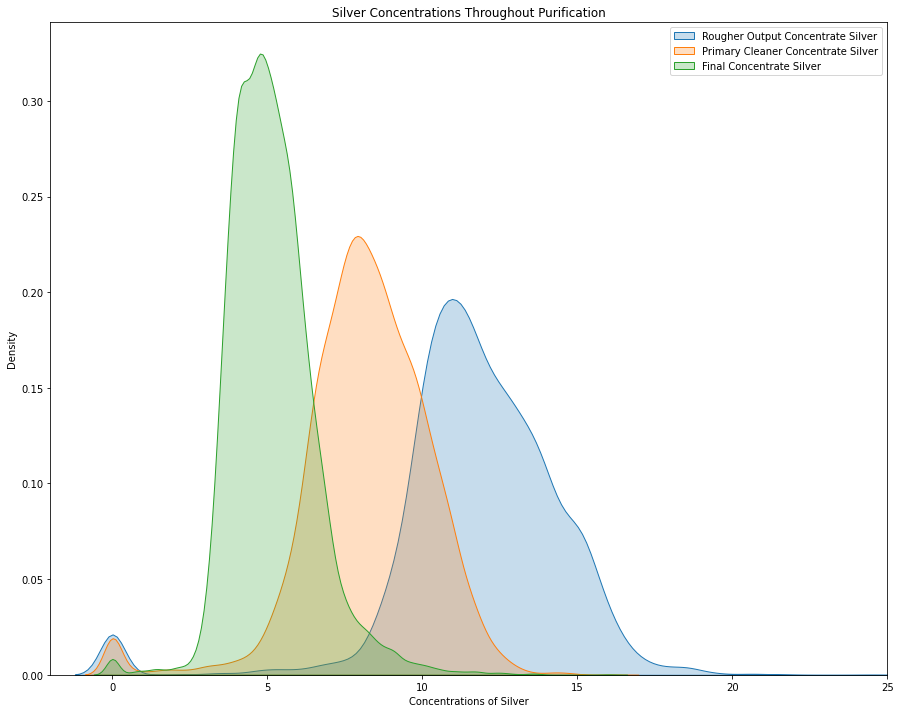

In [18]:
#plot the findings
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['rougher.output.concentrate_ag'], fill=True,label='Rougher Output Concentrate Silver')
sns.kdeplot(df_train['primary_cleaner.output.concentrate_ag'], fill=True,label='Primary Cleaner Concentrate Silver')
sns.kdeplot(df_train['final.output.concentrate_ag'], fill=True,label='Final Concentrate Silver')

plt.legend()
plt.title('Silver Concentrations Throughout Purification')
plt.xlabel('Concentrations of Silver')
plt.xlim(-2,25)

plt.show()

In [19]:
#lead
display(df_train['rougher.output.concentrate_pb'].describe())
display(df_train['primary_cleaner.output.concentrate_pb'].describe())
display(df_train['final.output.concentrate_pb'].describe())

count    14149.000000
mean         7.664555
std          1.856279
min          0.000000
25%          6.850501
50%          7.760435
75%          8.601927
max         13.617072
Name: rougher.output.concentrate_pb, dtype: float64

count    14149.000000
mean         9.590957
std          2.686229
min          0.000000
25%          8.345274
50%          9.933520
75%         11.296639
max         17.081278
Name: primary_cleaner.output.concentrate_pb, dtype: float64

count    14149.000000
mean        10.132971
std          1.654872
min          0.000000
25%          9.297528
50%         10.297144
75%         11.170578
max         17.031899
Name: final.output.concentrate_pb, dtype: float64

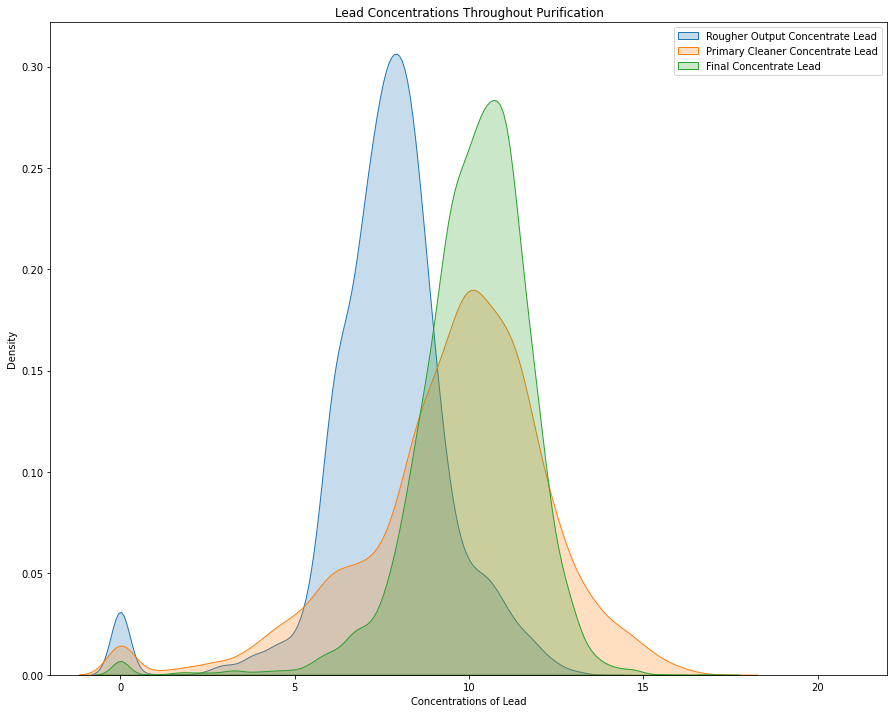

In [20]:
#plot the findings
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['rougher.output.concentrate_pb'], fill=True,label='Rougher Output Concentrate Lead')
sns.kdeplot(df_train['primary_cleaner.output.concentrate_pb'], fill=True,label='Primary Cleaner Concentrate Lead')
sns.kdeplot(df_train['final.output.concentrate_pb'], fill=True,label='Final Concentrate Lead')

plt.legend()
plt.title('Lead Concentrations Throughout Purification')
plt.xlabel('Concentrations of Lead')
plt.xlim(-2,22)

plt.show()

In [21]:
#gold
display(df_train['rougher.output.concentrate_au'].describe())
display(df_train['primary_cleaner.output.concentrate_au'].describe())
display(df_train['final.output.concentrate_au'].describe())

count    14149.000000
mean        19.439958
std          3.765192
min          0.000000
25%         18.432161
50%         19.947312
75%         21.392714
max         28.146838
Name: rougher.output.concentrate_au, dtype: float64

count    14149.000000
mean        32.386836
std          5.798843
min          0.000000
25%         30.857764
50%         33.225835
75%         35.330145
max         45.933934
Name: primary_cleaner.output.concentrate_au, dtype: float64

count    14149.000000
mean        44.003792
std          4.905261
min          0.000000
25%         43.276111
50%         44.872436
75%         46.166425
max         52.756638
Name: final.output.concentrate_au, dtype: float64

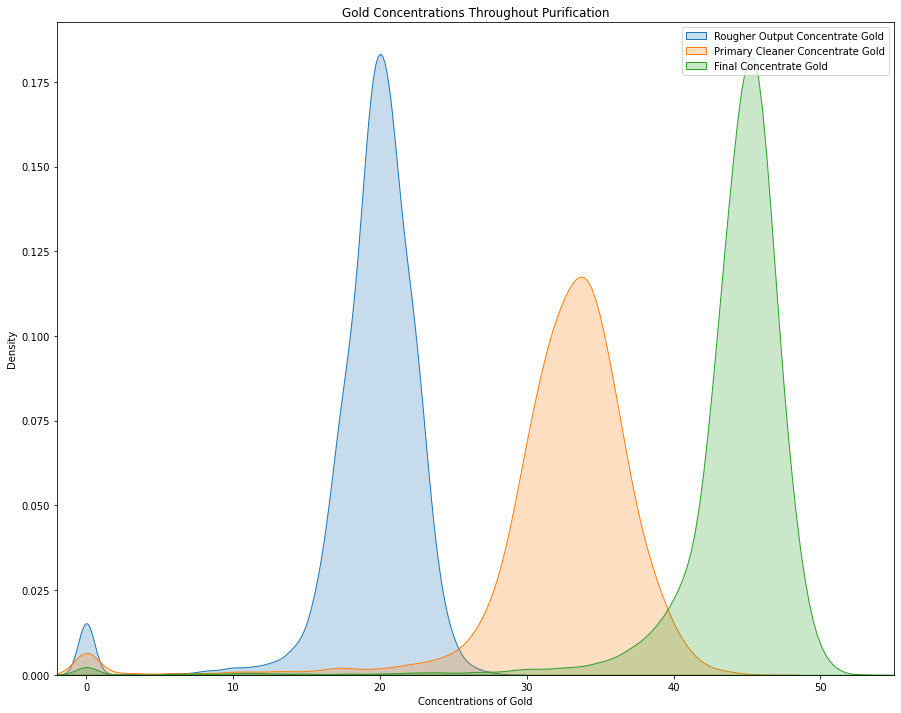

In [22]:
#plot the findings
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['rougher.output.concentrate_au'], fill=True,label='Rougher Output Concentrate Gold')
sns.kdeplot(df_train['primary_cleaner.output.concentrate_au'], fill=True,label='Primary Cleaner Concentrate Gold')
sns.kdeplot(df_train['final.output.concentrate_au'], fill=True,label='Final Concentrate Gold')

plt.legend()
plt.title('Gold Concentrations Throughout Purification')
plt.xlabel('Concentrations of Gold')
plt.xlim(-2,55)

plt.show()

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">

**Silver**: Throughout the cleaning process, the concentration of silver becomes less and less
    
**Lead**: Throughout the cleaning process, the concentration of lead decreases after the primary cleaning process, but then stays the same after the second
    
**Gold**: Throughout the cleaning process, the concentration of gold increases greatly throughout the purification process.

In [23]:
'''Consider the total concentrations of all substances at different stages: raw feed, rougher concentrate, and final concentrate
and check for abnormalities.

raw feed = rougher.input.feed_ag + rougher.input.feed_au + rougher.input.feed_pb
rougher concentrate = rougher.output.concentrate_ag + rougher.output.concentrate_au + rougher.output.concentrate_pb
final concentrate = final.output.concentrate_ag + final.output.concentrate_au + final.output.concentrate_pb'''

#raw feed
df_train['rougher.input.total'] = df_train['rougher.input.feed_ag'] + df_train['rougher.input.feed_au'] + df_train['rougher.input.feed_pb']

#rougher concentrate
df_train['rougher.output.total'] = df_train['rougher.output.concentrate_ag'] + df_train['rougher.output.concentrate_au'] + df_train['rougher.output.concentrate_pb']

#final concentrate
df_train['final.output.total'] = df_train['final.output.concentrate_ag'] + df_train['final.output.concentrate_au'] + df_train['final.output.concentrate_pb']

In [24]:
display(df_train['rougher.input.total'].describe())

count    14149.000000
mean        19.967843
std          4.396394
min          0.030000
25%         16.850944
50%         19.179708
75%         22.571605
max         32.840164
Name: rougher.input.total, dtype: float64

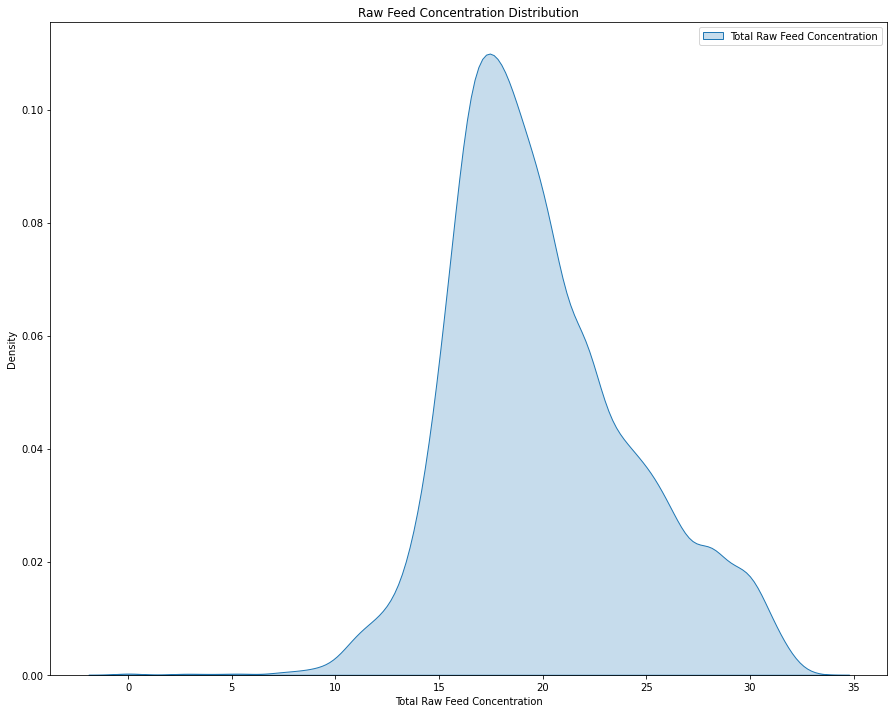

In [25]:
#plot the total raw feed
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['rougher.input.total'], fill=True,label='Total Raw Feed Concentration')

plt.legend()
plt.title('Raw Feed Concentration Distribution')
plt.xlabel('Total Raw Feed Concentration')


plt.show()

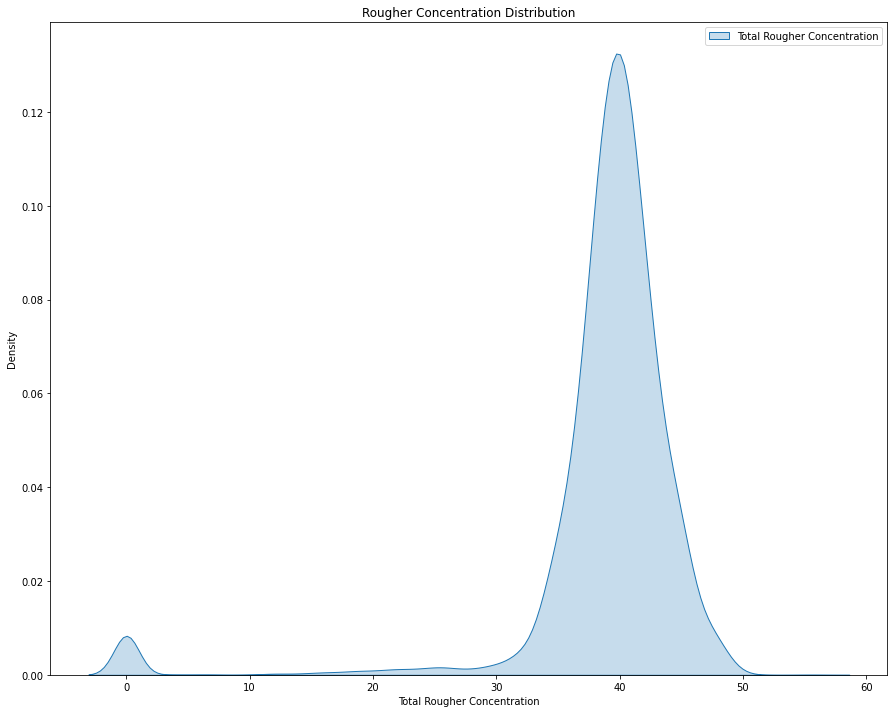

In [26]:
#plot the total raw feed
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['rougher.output.total'], fill=True,label='Total Rougher Concentration')

plt.legend()
plt.title('Rougher Concentration Distribution')
plt.xlabel('Total Rougher Concentration')


plt.show()

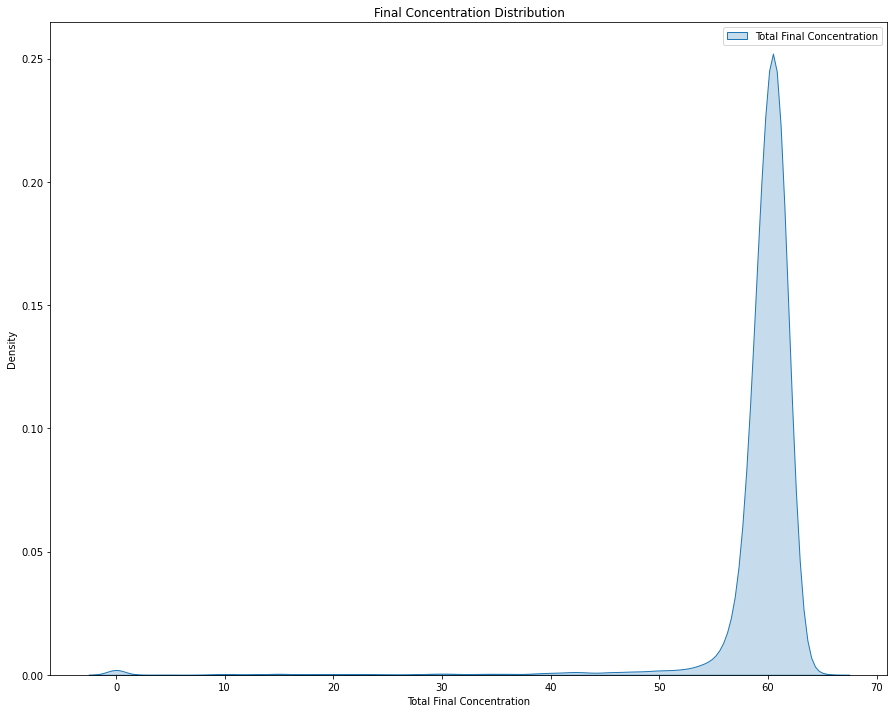

In [27]:
#plot the total raw feed
plt.figure(figsize=[15,12])

sns.kdeplot(df_train['final.output.total'], fill=True,label='Total Final Concentration')

plt.legend()
plt.title('Final Concentration Distribution')
plt.xlabel('Total Final Concentration')


plt.show()

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
The distributions of all the total concentrations look normal other than some 0's as outliers. I believe these outlier records should be removed so they are not trained in the model.

In [28]:
#remove total concentration rows of 0
df_train = df_train[(df_train[['rougher.input.total','rougher.output.total','final.output.total']] != 0).all(axis=1)]

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13795 entries, 0 to 16859
Data columns (total 90 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                13795 non-null  object 
 1   final.output.concentrate_ag                         13795 non-null  float64
 2   final.output.concentrate_pb                         13795 non-null  float64
 3   final.output.concentrate_sol                        13795 non-null  float64
 4   final.output.concentrate_au                         13795 non-null  float64
 5   final.output.recovery                               13795 non-null  float64
 6   final.output.tail_ag                                13795 non-null  float64
 7   final.output.tail_pb                                13795 non-null  float64
 8   final.output.tail_sol                               13795 non-null  float64


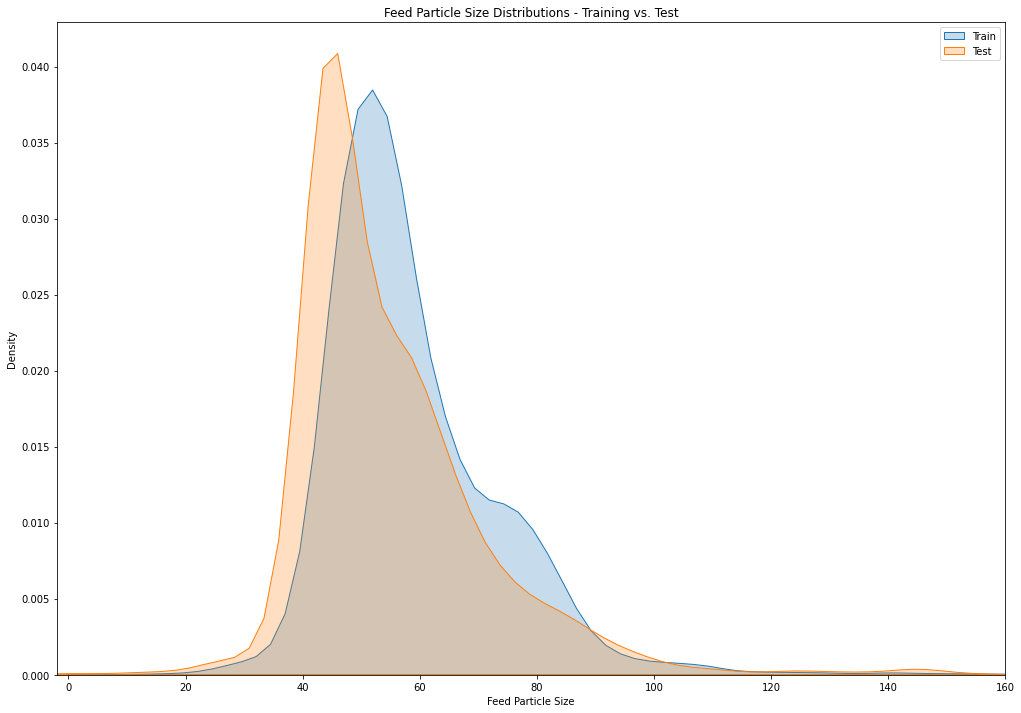

In [30]:
#Compare the feed particle size distributions in the training set and in the test set. 

#rougher input

plt.figure(figsize=[17,12])

sns.kdeplot(df_train['rougher.input.feed_size'], fill=True,label='Train')
sns.kdeplot(df_test['rougher.input.feed_size'], fill=True,label='Test')

plt.legend()
plt.title('Feed Particle Size Distributions - Training vs. Test')
plt.xlabel('Feed Particle Size')
plt.xlim(-2,160)

plt.show()

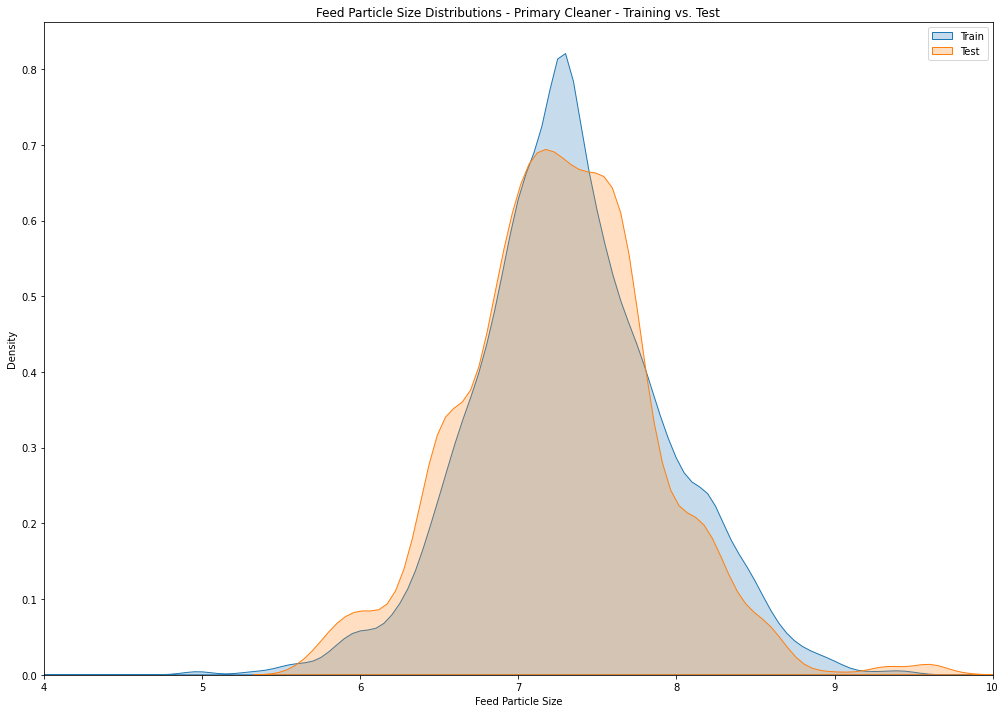

In [31]:
#primary cleaning input

plt.figure(figsize=[17,12])

sns.kdeplot(df_train['primary_cleaner.input.feed_size'], fill=True,label='Train')
sns.kdeplot(df_test['primary_cleaner.input.feed_size'], fill=True,label='Test')

plt.legend()
plt.title('Feed Particle Size Distributions - Primary Cleaner - Training vs. Test')
plt.xlabel('Feed Particle Size')
plt.xlim(4,10)

plt.show()

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
There are no significant differences between the distributions of these features in the train and test dataframes, so we can continue.

In [32]:
#check missing columns in each set
# Align the columns in the test set with the columns in the training set using list comprehension
not_in_test = [x for x in df_full.columns if x not in df_test.columns]

In [33]:
not_in_test

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
According to the list of features contained in the training set, but not in the test set, we want to match those dataframes up and add the two recovery

In [34]:
# merge target values from full dataset to test
df_test = pd.merge(df_test, df_full[['date','final.output.recovery','rougher.output.recovery']],on='date',how='left')

#remove 0s from the target
df_test = df_test[(df_test[['final.output.recovery','rougher.output.recovery']] != 0).all(axis=1)]

In [35]:
# drop features not in df_test from df_train
df_train = df_train.drop([x for x in df_train if x not in df_test], axis=1)

# drop features not in df_train from df_test
df_test = df_test.drop([x for x in df_test if x not in df_train], axis=1)

#drop date from both dataframes
df_train = df_train.drop(['date'], axis=1)
df_test = df_test.drop(['date'], axis=1)

In [ ]:
df_train.info()

In [ ]:
df_test.info()

In [36]:
'''There are missing values for the recovery features in the test set. Using median or mean would not have 
the correct calculations for the recovery.

I researched the dates in each dataframe I was joining and both had the same format, I tried merges using different and multiple
features, but I could not get the missing values amount to drop. I will drop these missing values despite it dropping 10% of the
test data.'''

df_test = df_test.dropna()

In [37]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5154 entries, 0 to 5855
Data columns (total 54 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5154 non-null   float64
 1   primary_cleaner.input.depressant            5154 non-null   float64
 2   primary_cleaner.input.feed_size             5154 non-null   float64
 3   primary_cleaner.input.xanthate              5154 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5154 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5154 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5154 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5154 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5154 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5154 non-null   float64
 10  primary_clea

#### <span style="color:skyblue">Last Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
   
The data is free of missing values, duplicates, and the data types look good. We are ready to move on and preprocess the data for model training.

## Machine Learning Model

In [38]:
#split into features and target

'''
I will be training models to predict the rougher concentration recovery and the final concentration recovery. 

To do this: For the rougher recovery, I will only pull features related to the flotation process, then for the final,
I will attach the predictions of the rougher model to the overall features set and train a model to find the final output recovery.
'''

#rougher concentration
features_train_ro = df_train.iloc[:, 14:24]
target_train_ro = df_train['rougher.output.recovery']

features_test_ro = df_test.iloc[:, 13:23]
target_test_ro = df_test['rougher.output.recovery']

### Rougher Concentrate Output - Random Forest Regressor

In [ ]:
#find the best random forest regressor using a parameter grid of different hyperparamters and displaying the best results
param_grid = {
    'n_estimators': [30,50,70],
    'max_depth': [5, 10,12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rfr = RandomForestRegressor(random_state=12345)

grid_search = GridSearchCV(estimator=rfr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [ ]:
#train the grid search to the data. this has a long run time
grid_search.fit(features_train_ro, target_train_ro)

In [ ]:
#get the best parameters, best score, best estimator
best_params = grid_search.best_params_
best_score = grid_search.best_score_
best_estimator = grid_search.best_estimator_

In [ ]:
#display results
display(best_params)
display(best_score)
display(best_estimator)

Results:

{'max_depth': 12,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 30}
 
-0.01563570041088086

RandomForestRegressor(max_depth=12, min_samples_split=5, n_estimators=30,
                      random_state=12345)

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
Our best Random Forest Regressor from the grid search didn't give us a great model, so I will experiment with a Decision Tree Regressor to see if we can get a better result.

### Rougher Concentrate Output - Decision Tree Regressor

In [56]:
#same thing with a decision tree regressor
#define parameter grid
param_grid_tree = {
    'max_depth': [3, 5, 7, 9, 11, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

#create Decision Tree Regressor
dtr = DecisionTreeRegressor(random_state=12345)

grid_search_tree = GridSearchCV(estimator=dtr, param_grid=param_grid_tree, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [57]:
#train the grid search to the data
grid_search_tree.fit(features_train_ro, target_train_ro)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 15, 20],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             scoring='neg_mean_squared_error')

In [63]:
#get the best parameters, best score, and cross validation results
best_params_tree = grid_search_tree.best_params_
best_estimator_fi = grid_search_fi.best_estimator_
best_score_tree = grid_search_tree.best_score_

In [64]:
#display results
display(best_params_tree)
display(best_estimator_fi)
display(best_score_tree)

{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}

DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, random_state=12345)

-0.052688485081853184

Results:

{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 2}

DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, random_state=12345)

-0.052688485081853184

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
I was able to get some really good MSE scores with both the Regression Forest (0.01) and the Decision Tree (0.05).
    
Due to run time and difference in score, I will continue to make predictions with the Decision Tree model configuration I have. First, I'll run a cross validation score on an untrained model to evaluate.

In [65]:
model = DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, random_state=12345)

scores = cross_val_score(model,features_train_ro,target_train_ro,cv=5)

final_score = sum(scores) / len(scores)

print('Average model evaluation score:', final_score)

Average model evaluation score: 0.993817170229305


#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">

A cross-validation score of 0.99 would indicate a very low MSE, meaning that the model's predictions are very close to the true values on average. I will continue with this model.


In [40]:
#train the selected model and get predictions array
model.fit(features_train_ro,target_train_ro)
predictions_ro = model.predict(features_test_ro)

#create predictions from training set as well to add to the final training feature dataframe
predictions_ro_train = model.predict(features_train_ro)

### Final Concentrate Output

In [41]:
# create features and target for the final output

features_train_fi = df_train.drop(['final.output.recovery'],axis=1)
features_train_fi['rougher.output.recovery.predictions'] = predictions_ro_train
target_train_fi = df_train['final.output.recovery']

features_test_fi = df_test.drop(['final.output.recovery'],axis=1)
features_test_fi['rougher.output.recovery.predictions'] = predictions_ro
target_test_fi = df_test['final.output.recovery']

### Final Concentrate Output - Linear Regression

In [42]:
# Use Linear Regression model on the final features and see if it can predict our target. Test using MSE

model_fi_lr = LinearRegression()

model_fi_lr.fit(features_train_fi,target_train_fi)

LinearRegression()

In [43]:
predictions_fi_lr = model_fi_lr.predict(features_test_fi)

In [44]:
mse = mean_squared_error(target_test_fi,predictions_fi_lr)

In [45]:
mse

436975672106.662

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
The linear regression model doesn't have the best performance either. I will go back to the GridSearchCV method and find the best Decision Tree Regressor model to use.

### Final Concentrate Output - Decision Tree Regressor

In [54]:
#find the best decision tree regressor using a parameter grid of different hyperparamters and displaying the best results
param_grid_fi = {
    'max_depth': [5,10,15,20,25,30,40,50],
    'min_samples_split': [2,5,10,15,20],
    'min_samples_leaf': [1,2,4,8]
}

dtr = DecisionTreeRegressor(random_state=12345)

grid_search_fi = GridSearchCV(estimator=dtr, param_grid=param_grid_fi, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

In [55]:
#train the grid search to the data
grid_search_fi.fit(features_train_fi, target_train_fi)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4, 8],
                         'min_samples_split': [2, 5, 10, 15, 20]},
             scoring='neg_mean_squared_error')

In [59]:
#get the best score, best estimator
best_score_fi = grid_search_fi.best_score_
best_estimator_fi = grid_search_fi.best_estimator_

In [60]:
#display results
display(best_score_fi)
display(best_estimator_fi)

-64.85994576011736

DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, random_state=12345)

Results:

-64.85994576011736

DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, random_state=12345)

In [62]:
#create and get a cross validation score for the optimal Decision Tree model.
model_dt_fi = DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, random_state=12345)

scores = cross_val_score(model_dt_fi,features_train_fi,target_train_fi,cv=5)

final_score = sum(scores) / len(scores)

print('Average model evaluation score:', final_score)

Average model evaluation score: 0.20246068555329058


#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
The average cross val score shows that the model doesn't appear to be predicting our target very well. It is performing better than the Linear Regression model and is average, so I will use it to train with the data and plug the predictions into an sMAPE function.

In [66]:
#train the model
model_dt_fi.fit(features_train_fi,target_train_fi)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=8, random_state=12345)

In [67]:
#get predictions
predictions_dt_fi = model_dt_fi.predict(features_test_fi)

In [68]:
mse_dt = mean_squared_error(target_test_fi,predictions_dt_fi)

In [69]:
mse_dt

70.23797889627517

#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">

Given the scale of all of our features, this is a pretty good MSE. I will use these predictions in our final metric to measure performance between both models.

### Final sMAPE Calculation 

In [70]:
#First, create dummy regressor models to compare our result to at the end. I'll have it compare the medians of the targets.
#for rougher concentrate
dummy_regr_ro = DummyRegressor(strategy="median")
dummy_regr_ro.fit(features_train_ro,target_train_ro)
dummy_predictions_ro = dummy_regr_ro.predict(features_test_ro)


#for final concentrate
dummy_regr_fi = DummyRegressor(strategy="median")
dummy_regr_fi.fit(features_train_fi,target_train_fi)
dummy_predictions_fi = dummy_regr_fi.predict(features_test_fi)

In [71]:
'''To solve our problem, we want to use the symmetric Mean Absolute Percentage Error metric.
    We want to equally take into account the scale of both the target and the prediction.'''


def final_smape(target_test_ro,predictions_ro,target_test_fi,predictions_fi):
    
    
    smape_ro = 1 / len(target_test_ro) * np.sum(np.abs(target_test_ro - predictions_ro) / ((np.abs(target_test_ro) + np.abs(predictions_ro)) / 2)) * 100
    smape_fi = 1 / len(target_test_fi) * np.sum(np.abs(target_test_fi - predictions_fi) / ((np.abs(target_test_fi) + np.abs(predictions_fi)) / 2)) * 100
    final_smape = (0.25 * smape_ro) + (0.75 * smape_fi)

    return final_smape


In [72]:
print('Final sMAPE Score:',final_smape(target_test_ro,predictions_ro,target_test_fi,predictions_dt_fi))
print('Final sMAPE Score for Dummy Regressor:',final_smape(target_test_ro,dummy_predictions_ro,target_test_fi,dummy_predictions_fi))

Final sMAPE Score: 10.33614071590057
Final sMAPE Score for Dummy Regressor: 7.363660673394497


#### <span style="color:skyblue">Observations</span>
<div style="border-radius: 15px; border: 3px solid skyblue; padding: 15px;">
    
My dummy regressor outperformed my actual model's predictions. The final output model did not predict the targets particularly well and that may be due to the rougher and final total concentration's having 0's as outliers. 
    
I went back and removed the concentrations that totaled to 0 in the training and test sets. This resulted in score changes of 6% improvement on my Decision Tree model and 2% improvement on the dummy regressor model.
    
    Before dropping 0's:
        Final sMAPE Score: 16%
        Final sMAPE Score for Dummy Regressor: 9%
    
    After dropping 0's:
        Final sMAPE Score: 10%
        Final sMAPE Score for Dummy Regressor: 7%

## Conclusion


In this project: 

 - I became familiar with the recovery process of gold and other metals from their ores,
 - I analyzed the processes of retrieving metal from the flotation stage and purification stages, 
 - I created models that could predict how much gold we retreive through each process and 
 - used the sMAPE metric to measure how well we could predict these outcomes.
 
At the end, I came out with a final sMAPE score between the 2 models of 10.3%. 

With our percentage of 10.3% through our 2 models, we see that my model's predictions matches the actual recoveries of gold at an excellent rate. 

For our client, Zyfra, they can use these model to predict how much gold they will get from their ores and will be crucial for their operational planning.